=== 1) Feature Selection GA ===
[FS] Gen 1/18 - avg=0.9514, max=0.9648
[FS] Gen 2/18 - avg=0.9550, max=0.9692
[FS] Gen 3/18 - avg=0.9588, max=0.9692
[FS] Gen 4/18 - avg=0.9602, max=0.9715
[FS] Gen 5/18 - avg=0.9648, max=0.9781
[FS] Gen 6/18 - avg=0.9652, max=0.9781
[FS] Gen 7/18 - avg=0.9676, max=0.9781
[FS] Gen 8/18 - avg=0.9656, max=0.9781
[FS] Gen 9/18 - avg=0.9667, max=0.9781
[FS] Gen 10/18 - avg=0.9686, max=0.9780
[FS] Gen 11/18 - avg=0.9663, max=0.9781
[FS] Gen 12/18 - avg=0.9668, max=0.9780
[FS] Gen 13/18 - avg=0.9698, max=0.9781
[FS] Gen 14/18 - avg=0.9695, max=0.9780
[FS] Gen 15/18 - avg=0.9676, max=0.9758
[FS] Gen 16/18 - avg=0.9675, max=0.9781
[FS] Gen 17/18 - avg=0.9687, max=0.9803
[FS] Gen 18/18 - avg=0.9665, max=0.9759

[FS RESULT] Mejor fitness (CV) = 0.9803
[FS RESULT] Número de features seleccionadas: 12
[FS RESULT] Features: [np.str_('mean texture'), np.str_('mean concavity'), np.str_('mean fractal dimension'), np.str_('texture error'), np.str_('smoothness error'), np

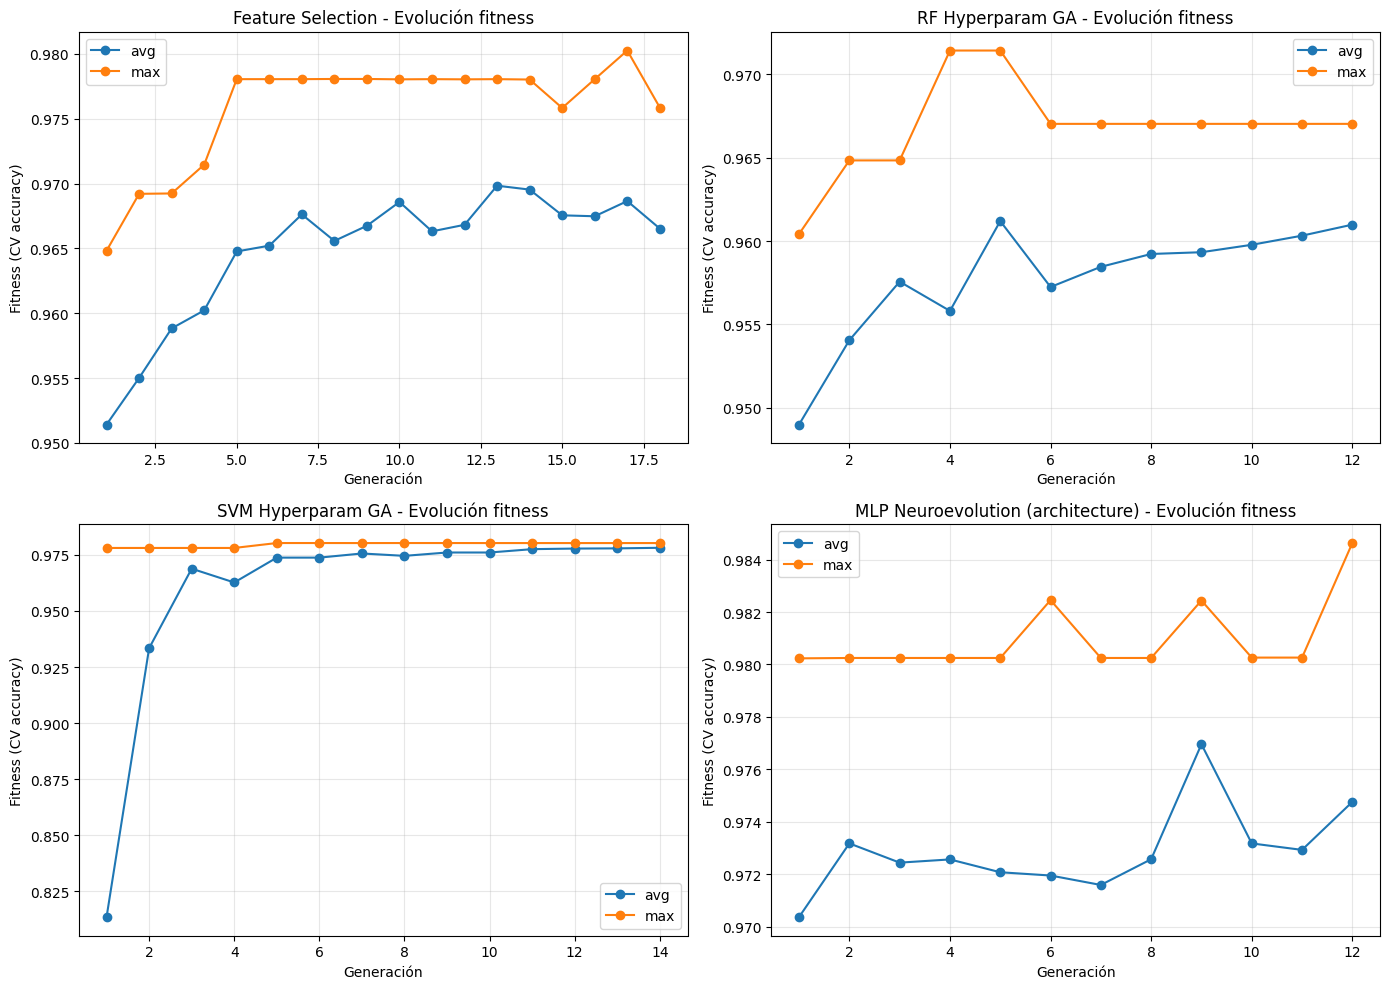


RESUMEN COMPARATIVO EN CONJUNTO DE PRUEBA (test set):
RandomForest (GA) test accuracy: 0.9561
SVM (GA) test accuracy:          0.9737
MLP (GA) test accuracy:          0.9737


In [1]:
"""
ga_examples.py

Integración de:
 - Feature Selection con Algoritmo Genético (GA)
 - Hyperparameter Optimization con GA para RandomForest
 - Hyperparameter Optimization con GA para SVM (estilo Grid Search evolutivo)
 - "Neuroevolution" (evolución de arquitectura y algunos hiperparámetros de MLPClassifier)

Dataset: sklearn.datasets.load_breast_cancer

Requisitos:
  - numpy
  - pandas
  - scikit-learn
  - matplotlib
"""

import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from copy import deepcopy

from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score

# -------------------------
# Reproducibilidad
SEED = 42
np.random.seed(SEED)
random.seed(SEED)

# -------------------------
# Cargar datos y preprocesamiento
data = load_breast_cancer()
X = data.data
y = data.target
feature_names = data.feature_names
n_features = X.shape[1]

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.2, random_state=SEED, stratify=y
)

# -------------------------
# FUNCIONES GENÉRICAS DEL GA
def tournament_selection(population, fitnesses, k=3):
    selected = []
    pop_size = len(population)
    for _ in range(pop_size):
        idxs = np.random.choice(pop_size, k, replace=False)
        best = idxs[np.argmax([fitnesses[i] for i in idxs])]
        selected.append(deepcopy(population[best]))
    return selected

def one_point_crossover(parent1, parent2):
    # parents are lists or arrays of same length
    if len(parent1) != len(parent2):
        raise ValueError("Parents length mismatch")
    if np.random.rand() < 0.9:
        pt = np.random.randint(1, len(parent1))
        child1 = np.concatenate([parent1[:pt], parent2[pt:]])
        child2 = np.concatenate([parent2[:pt], parent1[pt:]])
    else:
        child1, child2 = deepcopy(parent1), deepcopy(parent2)
    return child1, child2

# -------------------------
# 1) FEATURE SELECTION GA (cromosoma: vector binario de longitud n_features)
# -------------------------
def create_fs_individual():
    # Probabilidad inicial de incluir una característica = 0.5
    return np.random.choice([0, 1], size=n_features).astype(int)

def fitness_fs(individual, cv=3):
    # If no features chosen -> very low fitness
    if individual.sum() == 0:
        return 0.0
    selected_idx = np.where(individual == 1)[0]
    X_sel = X_train[:, selected_idx]
    model = RandomForestClassifier(random_state=SEED, n_jobs=-1)
    try:
        score = cross_val_score(model, X_sel, y_train, cv=cv, n_jobs=-1).mean()
    except Exception:
        score = 0.0
    return score

def mutate_fs(individual, mutation_rate=0.05):
    ind = individual.copy()
    for i in range(len(ind)):
        if np.random.rand() < mutation_rate:
            ind[i] = 1 - ind[i]  # flip
    return ind

def run_feature_selection_ga(pop_size=30, generations=20, cx_rate=0.8, mut_rate=0.05):
    pop = [create_fs_individual() for _ in range(pop_size)]
    best = None
    best_fit = -np.inf
    history = []

    for gen in range(generations):
        fits = [fitness_fs(ind) for ind in pop]
        avg = np.mean(fits)
        history.append((avg, np.max(fits)))
        # update best
        idx_best = np.argmax(fits)
        if fits[idx_best] > best_fit:
            best_fit = fits[idx_best]
            best = deepcopy(pop[idx_best])
        print(f"[FS] Gen {gen+1}/{generations} - avg={avg:.4f}, max={np.max(fits):.4f}")

        # Selection
        selected = tournament_selection(pop, fits, k=3)

        # Crossover
        new_pop = []
        for i in range(0, pop_size, 2):
            p1 = selected[i]
            p2 = selected[i+1] if i+1 < pop_size else selected[0]
            if np.random.rand() < cx_rate:
                c1, c2 = one_point_crossover(p1, p2)
            else:
                c1, c2 = deepcopy(p1), deepcopy(p2)
            new_pop.extend([c1, c2])

        # Mutation
        pop = [mutate_fs(ind, mutation_rate=mut_rate) for ind in new_pop[:pop_size]]

    return best, best_fit, history

# -------------------------
# 2) HYPERPARAM GA para RandomForest (basado en tu primer código, cromosoma: dict)
# -------------------------
def create_rf_individual():
    return {
        'n_estimators': int(np.random.randint(50, 301)),
        'max_depth': int(np.random.randint(3, 31)),
        'min_samples_split': int(np.random.randint(2, 11)),
        'min_samples_leaf': int(np.random.randint(1, 6)),
        'max_features': np.random.choice(['sqrt', 'log2', None]),
        'bootstrap': np.random.choice([True, False])
    }

def fitness_rf(individual, cv=3):
    try:
        model = RandomForestClassifier(
            n_estimators=individual['n_estimators'],
            max_depth=individual['max_depth'],
            min_samples_split=individual['min_samples_split'],
            min_samples_leaf=individual['min_samples_leaf'],
            max_features=individual['max_features'],
            bootstrap=individual['bootstrap'],
            random_state=SEED,
            n_jobs=-1
        )
        score = cross_val_score(model, X_train, y_train, cv=cv, n_jobs=-1).mean()
    except Exception:
        score = 0.0
    return score

def crossover_rf(p1, p2, cx_rate=0.9):
    if np.random.rand() < cx_rate:
        child1, child2 = deepcopy(p1), deepcopy(p2)
        numeric = ['n_estimators', 'max_depth', 'min_samples_split', 'min_samples_leaf']
        for param in numeric:
            if np.random.rand() < 0.5:
                child1[param], child2[param] = child2[param], child1[param]
        cat = ['max_features', 'bootstrap']
        for param in cat:
            if np.random.rand() < 0.5:
                child1[param], child2[param] = child2[param], child1[param]
        return child1, child2
    else:
        return deepcopy(p1), deepcopy(p2)

def mutate_rf(ind, mut_rate=0.15):
    out = deepcopy(ind)
    if np.random.rand() < mut_rate:
        out['n_estimators'] = int(np.random.randint(50, 301))
    if np.random.rand() < mut_rate:
        out['max_depth'] = int(np.random.randint(3, 31))
    if np.random.rand() < mut_rate:
        out['min_samples_split'] = int(np.random.randint(2, 11))
    if np.random.rand() < mut_rate:
        out['min_samples_leaf'] = int(np.random.randint(1, 6))
    if np.random.rand() < mut_rate:
        out['max_features'] = np.random.choice(['sqrt', 'log2', None])
    if np.random.rand() < mut_rate:
        out['bootstrap'] = np.random.choice([True, False])
    return out

def run_rf_ga(pop_size=20, generations=12, cx_rate=0.8, mut_rate=0.2):
    pop = [create_rf_individual() for _ in range(pop_size)]
    best = None; best_fit = -np.inf
    history = []

    for gen in range(generations):
        fits = [fitness_rf(ind) for ind in pop]
        avg = np.mean(fits); history.append((avg, np.max(fits)))
        idx_best = np.argmax(fits)
        if fits[idx_best] > best_fit:
            best_fit = fits[idx_best]; best = deepcopy(pop[idx_best])
        print(f"[RF-GA] Gen {gen+1}/{generations} - avg={avg:.4f}, max={np.max(fits):.4f}")

        selected = tournament_selection(pop, fits, k=3)
        new_pop = []
        for i in range(0, pop_size, 2):
            p1 = selected[i]
            p2 = selected[i+1] if i+1 < pop_size else selected[0]
            c1, c2 = crossover_rf(p1, p2, cx_rate=cx_rate)
            new_pop.extend([c1, c2])
        pop = [mutate_rf(ind, mut_rate) for ind in new_pop[:pop_size]]

    return best, best_fit, history

# -------------------------
# 3) HYPERPARAM GA para SVM (C, gamma) - cromosoma: array [C_log10, gamma_log10, kernel_index(optional)]
#    C = 10**C_log10, gamma = 10**gamma_log10
# -------------------------
def create_svm_individual():
    # C in 1e-3 .. 1e3 => log10 in [-3, 3]
    # gamma in 1e-4 .. 1e-1 => log10 in [-4, -1]
    return np.array([
        np.random.uniform(-3.0, 3.0),   # C_log10
        np.random.uniform(-4.0, -1.0),  # gamma_log10
        0  # kernel index for 'rbf' only for now (reserved)
    ])

def fitness_svm(individual, cv=3):
    C = 10.0 ** individual[0]
    gamma = 10.0 ** individual[1]
    try:
        model = SVC(C=C, gamma=gamma, kernel='rbf', random_state=SEED)
        score = cross_val_score(model, X_train, y_train, cv=cv, n_jobs=-1).mean()
    except Exception:
        score = 0.0
    return score

def mutate_svm(ind, mut_rate=0.2):
    out = ind.copy()
    if np.random.rand() < mut_rate:
        out[0] += np.random.normal(0, 0.5)  # perturb log C
        out[0] = np.clip(out[0], -5, 5)
    if np.random.rand() < mut_rate:
        out[1] += np.random.normal(0, 0.3)  # perturb log gamma
        out[1] = np.clip(out[1], -7, 1)
    return out

def crossover_svm(p1, p2, cx_rate=0.9):
    if np.random.rand() < cx_rate:
        child1 = p1.copy(); child2 = p2.copy()
        # uniform crossover on the two continuous genes
        for i in range(2):
            if np.random.rand() < 0.5:
                child1[i], child2[i] = child2[i], child1[i]
        return child1, child2
    else:
        return p1.copy(), p2.copy()

def run_svm_ga(pop_size=25, generations=14, cx_rate=0.8, mut_rate=0.2):
    pop = [create_svm_individual() for _ in range(pop_size)]
    best = None; best_fit = -np.inf; history = []
    for gen in range(generations):
        fits = [fitness_svm(ind) for ind in pop]
        avg = np.mean(fits); history.append((avg, np.max(fits)))
        idx_best = np.argmax(fits)
        if fits[idx_best] > best_fit:
            best_fit = fits[idx_best]; best = deepcopy(pop[idx_best])
        print(f"[SVM-GA] Gen {gen+1}/{generations} - avg={avg:.4f}, max={np.max(fits):.4f}")

        selected = tournament_selection(pop, fits, k=3)
        new_pop = []
        for i in range(0, pop_size, 2):
            p1 = selected[i]
            p2 = selected[i+1] if i+1 < pop_size else selected[0]
            c1, c2 = crossover_svm(p1, p2, cx_rate=cx_rate)
            new_pop.extend([c1, c2])
        pop = [mutate_svm(ind, mut_rate=mut_rate) for ind in new_pop[:pop_size]]

    return best, best_fit, history

# -------------------------
# 4) NEUROEVOLUTION (evolucionar arquitectura y algunos hiperparametros de MLP)
#    Cromosoma: dict con n_layers(1-3), neurons per layer list, activation, solver, alpha, learning_rate_init
# -------------------------
def create_mlp_individual():
    n_layers = np.random.randint(1, 4)  # 1 to 3 hidden layers
    neurons = [int(np.random.randint(8, 129)) for _ in range(n_layers)]
    activation = np.random.choice(['relu', 'tanh'])
    solver = np.random.choice(['adam', 'lbfgs'])
    lr = 10 ** np.random.uniform(-4, -1)  # 1e-4 .. 1e-1
    alpha = 10 ** np.random.uniform(-6, -2)  # regularization
    return {
        'hidden_layer_sizes': tuple(neurons),
        'activation': activation,
        'solver': solver,
        'learning_rate_init': lr,
        'alpha': alpha
    }

def fitness_mlp(individual, cv=3, max_iter=300):
    try:
        model = MLPClassifier(
            hidden_layer_sizes=individual['hidden_layer_sizes'],
            activation=individual['activation'],
            solver=individual['solver'],
            learning_rate_init=individual['learning_rate_init'],
            alpha=individual['alpha'],
            random_state=SEED,
            max_iter=max_iter
        )
        score = cross_val_score(model, X_train, y_train, cv=cv, n_jobs=-1).mean()
    except Exception as e:
        # numerical or convergence errors -> penalize
        score = 0.0
    return score

def crossover_mlp(p1, p2, cx_rate=0.9):
    if np.random.rand() < cx_rate:
        # mix layers: take some layers from p1 and some from p2
        l1 = list(p1['hidden_layer_sizes'])
        l2 = list(p2['hidden_layer_sizes'])
        # build child hidden layers by alternating up to max length
        maxlen = max(len(l1), len(l2))
        new_layers1, new_layers2 = [], []
        for i in range(maxlen):
            if np.random.rand() < 0.5:
                val1 = l1[i] if i < len(l1) else (l2[i] if i < len(l2) else np.random.randint(8, 129))
                val2 = l2[i] if i < len(l2) else (l1[i] if i < len(l1) else np.random.randint(8, 129))
            else:
                val1 = l2[i] if i < len(l2) else (l1[i] if i < len(l1) else np.random.randint(8, 129))
                val2 = l1[i] if i < len(l1) else (l2[i] if i < len(l2) else np.random.randint(8, 129))
            new_layers1.append(int(val1)); new_layers2.append(int(val2))
        # trim to 1-3 layers
        new_layers1 = new_layers1[:np.random.randint(1,4)]
        new_layers2 = new_layers2[:np.random.randint(1,4)]
        child1 = {
            'hidden_layer_sizes': tuple(new_layers1),
            'activation': p1['activation'] if np.random.rand() < 0.5 else p2['activation'],
            'solver': p1['solver'] if np.random.rand() < 0.5 else p2['solver'],
            'learning_rate_init': p1['learning_rate_init'] if np.random.rand() < 0.5 else p2['learning_rate_init'],
            'alpha': p1['alpha'] if np.random.rand() < 0.5 else p2['alpha']
        }
        child2 = {
            'hidden_layer_sizes': tuple(new_layers2),
            'activation': p2['activation'] if np.random.rand() < 0.5 else p1['activation'],
            'solver': p2['solver'] if np.random.rand() < 0.5 else p1['solver'],
            'learning_rate_init': p2['learning_rate_init'] if np.random.rand() < 0.5 else p1['learning_rate_init'],
            'alpha': p2['alpha'] if np.random.rand() < 0.5 else p1['alpha']
        }
        return child1, child2
    else:
        return deepcopy(p1), deepcopy(p2)

def mutate_mlp(ind, mut_rate=0.2):
    out = deepcopy(ind)
    if np.random.rand() < mut_rate:
        # mutate number of layers and neurons
        n_layers = np.random.randint(1,4)
        out['hidden_layer_sizes'] = tuple(int(np.random.randint(8,129)) for _ in range(n_layers))
    if np.random.rand() < mut_rate:
        out['activation'] = np.random.choice(['relu', 'tanh'])
    if np.random.rand() < mut_rate:
        out['solver'] = np.random.choice(['adam', 'lbfgs'])
    if np.random.rand() < mut_rate:
        out['learning_rate_init'] = 10 ** np.random.uniform(-4, -1)
    if np.random.rand() < mut_rate:
        out['alpha'] = 10 ** np.random.uniform(-6, -2)
    return out

def run_mlp_ga(pop_size=18, generations=12, cx_rate=0.8, mut_rate=0.25):
    pop = [create_mlp_individual() for _ in range(pop_size)]
    best = None; best_fit = -np.inf; history = []

    for gen in range(generations):
        fits = [fitness_mlp(ind) for ind in pop]
        avg = np.mean(fits); history.append((avg, np.max(fits)))
        idx_best = np.argmax(fits)
        if fits[idx_best] > best_fit:
            best_fit = fits[idx_best]; best = deepcopy(pop[idx_best])
        print(f"[MLP-GA] Gen {gen+1}/{generations} - avg={avg:.4f}, max={np.max(fits):.4f}")

        selected = tournament_selection(pop, fits, k=3)
        new_pop = []
        for i in range(0, pop_size, 2):
            p1 = selected[i]
            p2 = selected[i+1] if i+1 < pop_size else selected[0]
            c1, c2 = crossover_mlp(p1, p2, cx_rate=cx_rate)
            new_pop.extend([c1, c2])
        pop = [mutate_mlp(ind, mut_rate=mut_rate) for ind in new_pop[:pop_size]]

    return best, best_fit, history

# -------------------------
# EJECUCIÓN: Ejecutar los 4 métodos secuencialmente y mostrar resultados
# -------------------------
if __name__ == "__main__":
    print("=== 1) Feature Selection GA ===")
    fs_best, fs_best_fit, fs_hist = run_feature_selection_ga(pop_size=30, generations=18, cx_rate=0.9, mut_rate=0.06)
    chosen_idx = np.where(fs_best == 1)[0]
    print("\n[FS RESULT] Mejor fitness (CV) = {:.4f}".format(fs_best_fit))
    print("[FS RESULT] Número de features seleccionadas:", len(chosen_idx))
    print("[FS RESULT] Features:", [feature_names[i] for i in chosen_idx])

    print("\n=== 2) RandomForest Hyperparameter GA ===")
    rf_best, rf_best_fit, rf_hist = run_rf_ga(pop_size=20, generations=12, cx_rate=0.8, mut_rate=0.2)
    print("\n[RF-GA RESULT] Mejor fitness (CV) = {:.4f}".format(rf_best_fit))
    print("[RF-GA RESULT] Mejores hiperparámetros:", rf_best)

    # Entrenar y evaluar modelo final RF
    rf_final = RandomForestClassifier(**rf_best, random_state=SEED, n_jobs=-1)
    rf_final.fit(X_train, y_train)
    rf_test_acc = accuracy_score(y_test, rf_final.predict(X_test))
    print(f"[RF-GA RESULT] Accuracy en test: {rf_test_acc:.4f}")

    print("\n=== 3) SVM Hyperparameter GA (estilo GridSearch evolutivo) ===")
    svm_best, svm_best_fit, svm_hist = run_svm_ga(pop_size=25, generations=14, cx_rate=0.85, mut_rate=0.25)
    print("\n[SVM-GA RESULT] Mejor fitness (CV) = {:.4f}".format(svm_best_fit))
    C_best = 10.0 ** svm_best[0]; gamma_best = 10.0 ** svm_best[1]
    print(f"[SVM-GA RESULT] C={C_best:.6g}, gamma={gamma_best:.6g}")

    # Entrenar y evaluar SVM final
    svm_final = SVC(C=C_best, gamma=gamma_best, kernel='rbf', random_state=SEED)
    svm_final.fit(X_train, y_train)
    svm_test_acc = accuracy_score(y_test, svm_final.predict(X_test))
    print(f"[SVM-GA RESULT] Accuracy en test: {svm_test_acc:.4f}")

    print("\n=== 4) Neuroevolution (MLP architecture GA) ===")
    mlp_best, mlp_best_fit, mlp_hist = run_mlp_ga(pop_size=18, generations=12, cx_rate=0.85, mut_rate=0.25)
    print("\n[MLP-GA RESULT] Mejor fitness (CV) = {:.4f}".format(mlp_best_fit))
    print("[MLP-GA RESULT] Mejor arquitectura/params:", mlp_best)

    # Entrenar y evaluar MLP final
    mlp_final = MLPClassifier(
        hidden_layer_sizes=mlp_best['hidden_layer_sizes'],
        activation=mlp_best['activation'],
        solver=mlp_best['solver'],
        learning_rate_init=mlp_best['learning_rate_init'],
        alpha=mlp_best['alpha'],
        random_state=SEED,
        max_iter=500
    )
    mlp_final.fit(X_train, y_train)
    mlp_test_acc = accuracy_score(y_test, mlp_final.predict(X_test))
    print(f"[MLP-GA RESULT] Accuracy en test: {mlp_test_acc:.4f}")

    # -------------------------
    # Visualizaciones: Evolución del fitness para cada GA
    # -------------------------
    def plot_history(hist, title):
        gens = np.arange(1, len(hist)+1)
        avg = [h[0] for h in hist]
        mx = [h[1] for h in hist]
        plt.plot(gens, avg, marker='o', label='avg')
        plt.plot(gens, mx, marker='o', label='max')
        plt.xlabel('Generación')
        plt.ylabel('Fitness (CV accuracy)')
        plt.title(title)
        plt.grid(alpha=0.3)
        plt.legend()

    plt.figure(figsize=(14, 10))

    plt.subplot(2,2,1)
    plot_history(fs_hist, 'Feature Selection - Evolución fitness')

    plt.subplot(2,2,2)
    plot_history(rf_hist, 'RF Hyperparam GA - Evolución fitness')

    plt.subplot(2,2,3)
    plot_history(svm_hist, 'SVM Hyperparam GA - Evolución fitness')

    plt.subplot(2,2,4)
    plot_history(mlp_hist, 'MLP Neuroevolution (architecture) - Evolución fitness')

    plt.tight_layout()
    plt.show()

    # -------------------------
    # Resumen comparativo final
    # -------------------------
    print("\n" + "="*60)
    print("RESUMEN COMPARATIVO EN CONJUNTO DE PRUEBA (test set):")
    print(f"RandomForest (GA) test accuracy: {rf_test_acc:.4f}")
    print(f"SVM (GA) test accuracy:          {svm_test_acc:.4f}")
    print(f"MLP (GA) test accuracy:          {mlp_test_acc:.4f}")
    print("="*60)
